# Aprendizado Profundo

# Processamento dos dados

# Redes Generativas Adversárias

# Caso de uso

In [1]:
var = """
TODO: 
- Mostrar imagem do mapa
- Análise estatística para modelagem com ARIMA
""" 

In [2]:
import glob
import importlib
import pandas as pd
import numpy as np
import plotting as p
importlib.reload(p)
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [3]:
plt.style.use('seaborn')

## Leitura e descrição dos dados

In [4]:
bikes = pd.read_csv('datasets/bike_sharing_2011to2019.csv', index_col=0)
bikes.head()

,date,hour,cnt
0,2011-01-01,0,16
1,2011-01-01,1,40
2,2011-01-01,2,32
3,2011-01-01,3,13
4,2011-01-01,4,1


In [5]:
bikes['cnt'].describe()

count    78888.000000
mean       329.480884
std        337.722508
min          0.000000
25%         59.000000
50%        226.000000
75%        487.000000
max       2037.000000
Name: cnt, dtype: float64

TODO: Breve explicação das colunas

In [5]:
lista_datas = p.get_list_dates(data_size=bikes.shape[0], year=2011, month=1, day=1)

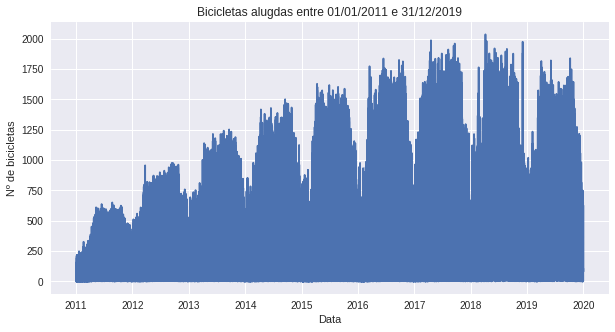

In [6]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(lista_datas, bikes['cnt'])
ax.set_xlabel("Data")
ax.set_ylabel("Nº de bicicletas")
ax.set_title("Bicicletas alugdas entre 01/01/2011 e 31/12/2019");

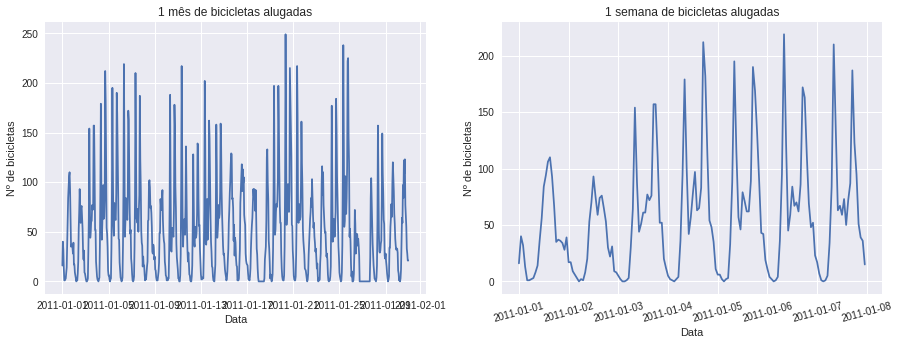

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(lista_datas[:30*24], bikes['cnt'].iloc[:30*24])
ax[0].set_xlabel("Data")
ax[0].set_ylabel("Nº de bicicletas")
ax[0].set_title("1 mês de bicicletas alugadas");
plt.xticks(rotation=15);
ax[1].plot(lista_datas[:7*24], bikes['cnt'].iloc[:7*24])
ax[1].set_xlabel("Data")
ax[1].set_ylabel("Nº de bicicletas")
ax[1].set_title("1 semana de bicicletas alugadas");
plt.xticks(rotation=15);

## Características esperadas

In [31]:
real_data = bikes['cnt'].values.reshape(bikes.shape[0]//24, 24)
df_real = p.get_df(list_dates=lista_datas, data=bikes[['cnt']].values, timesteps=24)
lista_cnt = [p.get_count(df_real,w,24, column='ts')['cnt_0'] for w in range(7)]

In [34]:
df_real

,date,cnt_0,wk,ts
0,2011-01-01 00:00:00,16,5,0
1,2011-01-01 01:00:00,40,5,1
2,2011-01-01 02:00:00,32,5,2
3,2011-01-01 03:00:00,13,5,3
4,2011-01-01 04:00:00,1,5,4
...,...,...,...,...
78883,2019-12-31 19:00:00,180,1,19
78884,2019-12-31 20:00:00,135,1,20
78885,2019-12-31 21:00:00,111,1,21
78886,2019-12-31 22:00:00,80,1,22


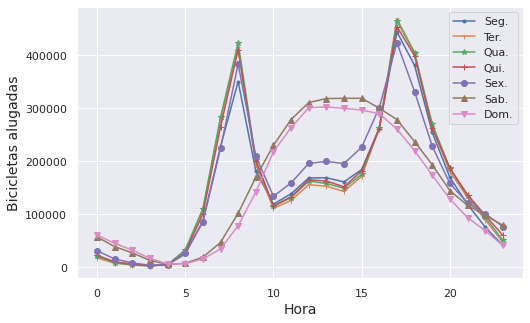

In [5]:
p.plot_sum_real(list_cnt_real=lista_cnt, list_dates=lista_datas)
plt.show()

In [4]:
path_lista_fakes = glob.glob('datasets/generated/*.npy')

In [55]:
import numpy as np

In [28]:
a = np.load(path_lista_fakes[0])

In [27]:
dict_weeks = {i:p.get_list_wks(path_lista_fakes, lista_datas, 24, wk=i) for i in range(7)}

In [44]:
a = np.array(dict_weeks[0][0])

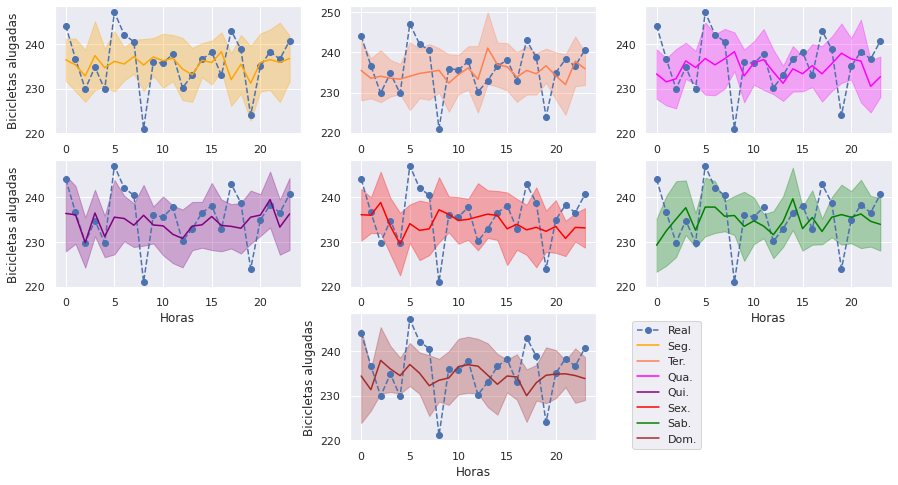

In [68]:
# 0, 3, 6
# 3, 6, 5
p.plot_compare_sum(dict_weeks, a, bbox=(1.45, -0.1))

In [57]:
ab = ['1','2']
bc = ['3','4']

In [60]:
['a']+bc

['a', '3', '4']

# Modelagem com o ARIMA

- Verificar se é estacionária
- Aplicar ajustes, se for necessário

In [10]:
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

In [11]:
adf_test = pm.arima.stationarity.ADFTest(alpha=0.05)
p_value, dif = adf_test.should_diff(bikes['cnt'].values)
print(p_value, dif)

0.01 False


In [4]:
treino = bikes['cnt'].iloc[:365*24].values

In [12]:
pm_auto = pm.auto_arima(treino, seasonal=True, maxiter=1, start_p=2, max_p=3, start_q=2, max_q=3, stationary=True, m=7)

In [13]:
order, seasonal_order = [pm_auto.order, pm_auto.seasonal_order]
print (order, seasonal_order)

(0, 0, 1, 7)

In [71]:
# ajusta um modelo arima nos dados de treinamento
m1 = ARIMA(treino, order=order, seasonal_order=seasonal_order)
res = m1.fit()

In [77]:
# gera 10 bases sinteticas com um modelo arima
for i in range(10):
    synth_arima = res.simulate(nsimulations=len(treino))
    np.save('datasets/generated/arima/arima_{}.npy'.format(i), synth_arima)

# GAN

In [ ]:
! pip install ydata-synthetic

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from ydata_synthetic.synthesizers import ModelParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries import TimeGAN

In [ ]:
# Specific to TimeGANs
seq_len=24
n_seq = 1
hidden_dim=24
gamma=1

noise_dim = 32
dim = 128
batch_size = 28

log_step = 100
learning_rate = 5e-4

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           noise_dim=noise_dim,
                           layers_dim=dim)

In [5]:
scaler = MinMaxScaler().fit(treino.reshape(-1,1))
treino_scaled = scaler.transform(treino.reshape(-1,1))
treino_s = treino_scaled.reshape(len(treino)//24, 24, 1)

In [ ]:
synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)
synth.train(treino_s, train_steps=3000)

In [ ]:
synth.save("modelos/minicurso_bike.pkl")

In [ ]:
for i in range(10):
    synth_data = synth.sample(len(treino_s))
    np.save("datasets/generated/timegan/timegan_{}.npy".format(i), synth_data)

In [8]:
treino_s = MinMaxScaler().fit_transform(treino.reshape(-1,1))
treino_s = treino_s.reshape(treino.shape[0],1)

In [9]:
df_sample = p.get_df(lista_datas[:365*24], treino_s, timesteps=24)
dict_weeks_real = {wk:p.get_count(df_sample,wk,timestep=24, column='ts')['cnt_0'] for wk in range(7)} 

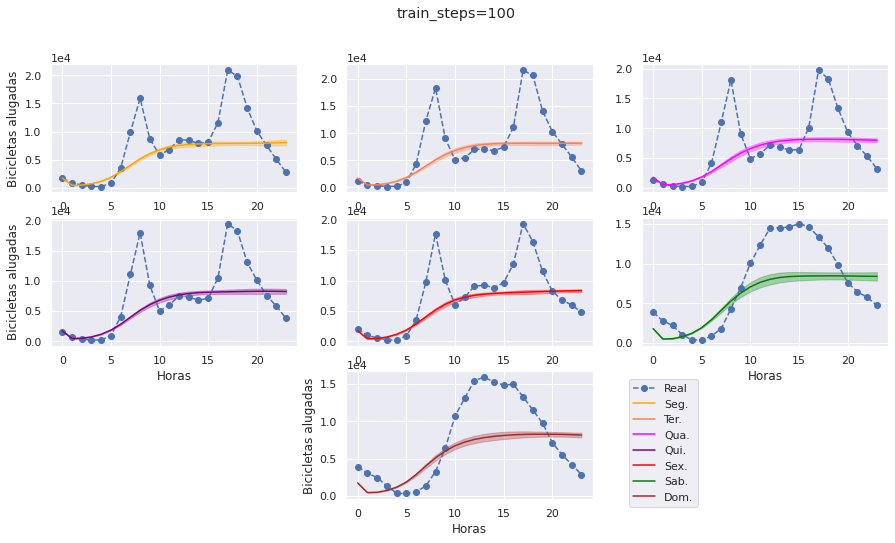

In [24]:
path_lista_fakes = glob.glob("datasets/generated/timegan/1/*.npy")
dict_weeks_fakes = {i:p.get_list_wks(path_lista_fakes, lista_datas[:365*24], 24, wk=i) for i in range(7)}
p.plot_compare_sum(dict_weeks_fakes,dict_weeks_real, bbox=(1.45, -0.1), figtitle="train_steps=100", scaler=scaler)

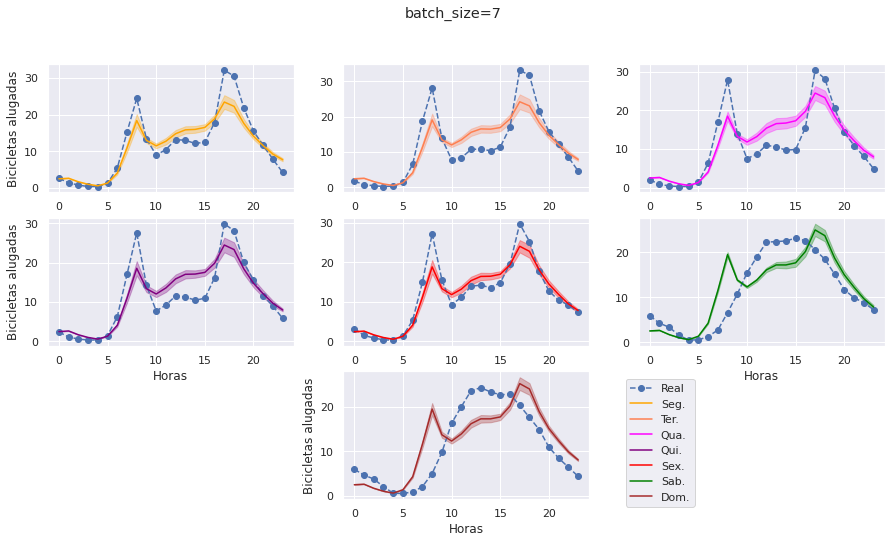

In [16]:
path_lista_fakes = glob.glob("datasets/generated/timegan/2/*.npy")
dict_weeks_fakes = {i:p.get_list_wks(path_lista_fakes, lista_datas[:365*24], 24, wk=i) for i in range(7)}
p.plot_compare_sum(dict_weeks_fakes, dict_weeks_real, bbox=(1.45, -0.1), figtitle="batch_size=7")

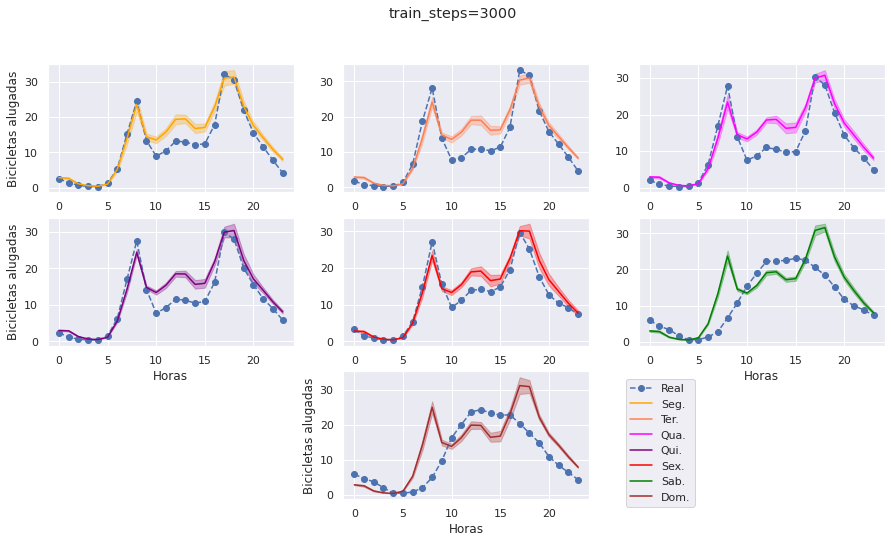

In [17]:
path_lista_fakes = glob.glob("datasets/generated/timegan/3/*.npy")
dict_weeks_fakes = {i:p.get_list_wks(path_lista_fakes, lista_datas[:365*24], 24, wk=i) for i in range(7)}
p.plot_compare_sum(dict_weeks_fakes,dict_weeks_real, bbox=(1.45, -0.1), figtitle="train_steps=3000")

## Treinamento

## Avaliação

In [6]:
import residuals as r
from keras.optimizers import Adam

In [7]:
rnn_model = r.make_rnn_model(units=32, n_layers=2, net_type='lstm')

In [8]:
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 24, 32)            4352      
                                                                 
 LSTM_2 (LSTM)               (None, 32)                8320      
                                                                 
 OUT (Dense)                 (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = Adam(learning_rate=5e-4)
rnn_model.compile(optimizer=opt, loss='mse')